# Representational Similarity Analysis assignment
The tutorial below is based on the two tutorials found here: 

https://brainiak.org/tutorials/06-rsa/

https://lukas-snoek.com/NI-edu/fMRI-pattern-analysis/week_3/rsa.html

## Portfolio assignment 4

The assignment written in the semester plan is as follows:

"fMRI/MEG representational similarity. Use data of your own choice. Can be data from
workshop or data from notebooks or something gathered online. Individual assignment,
max. 2 pages, excl. figures and references, code as appendix."

You are free to interpret the above as you please to make a fun and interesting assignmemt. However, if you want a more concretely stated assignment, here is one:

1. Go through the code below.
2. Change the analysis to be on one of the other participants and/or ROIs in the data.
3. Describe the analysis procedure, you have used (e.g. see Haynes 2015).
4. Report and discuss the results and the method.
5. Include at least one figure, which is not directly from the code.
6. Consider including answers to the following questions:

    a. How may representational similarity analysis answer questions, which univariate analyses cannot answer? Use your data as example to make sure that you go beyond a chatbot answer.

    b. Which questions in neuroscience would you consider most interesting to apply this method to and why?

    c. Which questions from cognitive science broadly benefits from analyses on representational similarity?




# Representational Similarity Analysis
[Contributions](#contributions)

Oranges and orange ping-pong balls are not kept next to each other in the grocery store. The oranges are usually placed with other fruits and ping-pong balls with other sport equipment. This helps us shop easily, as we usually group our shopping by categories: fruits and vegetables, meat and dairy, frozen foods, and, somewhere far away, kitchen supplies, toys and sports. Beyond grocery stores, are these meaningful conceptual groupings in the brain? Are patterns of neural activity for oranges and apples more similar to each other as compared to the patterns for oranges and ping-pong balls?

One could conceivably group items based on other attributes such as shape and color. This would make the neural representations of oranges and orange colored ping-pong balls very similar to each other. In a brain region that cares about color, the neural similarity would be greater for oranges and orange ping-pong balls, compared to oranges and red apples. How can we determine the similarity between neural representations and which attributes are driving this similarity?

Representational similarity analysis (RSA) is a way to compare and contrast different brain states and the stimuli that elicited them. In RSA, we compute a similarity measure (often a correlation) between patterns of neural activity for all items being compared. Then, to examine whether neural patterns in a brain region are grouped by color, shape, or category, we can order the similarity measure based on a model that groups by these attributes.

RSA is a highly versatile tool: it can be used to compare brain activity to models, compare data across brain imaging techniques, and even to make cross-species comparisons. You can learn more about the RSA method [here](https://doi.org/10.3389/neuro.06.004.2008) and [here](https://doi.org/10.1016/j.tics.2013.06.007).
    
## Goal of this script

>1. Learn how to perform RSA on a dataset
  >> Calculate and plot Pearson and Spearman correlations in ROIs  
  >> Order these similarity matrices in a meaningful way  
  >> Interpret a (dis)similarity matrix  
>2. Visualize similarity with multi dimensional scaling (MDS)


### Dataset <a id="preprocessing"></a> 

The dataset we will be using for this exercise is from [Kriegeskorte et al. (2008)](https://www.sciencedirect.com/science/article/pii/S0896627308009434), called 'Ninetysix' in the `datasets` folder. 96 visual stimuli, from the 6 categories listed below, were presented to participants. The image stimuli are stored in the subfolder `Stimuli`.

The data have 6 categories:  
    1. artificial inanimate (object/scene)
    2. human bodypart 
    3. human face 
    4. natural inanimate (object/scene)
    5. nonhuman bodypart
    6. nonhuman face

**Self-study:** Explore the data

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


## Download datasets for tutorials
We will work on the NinetySix dataset. Download and unzip if not already in the data folder.

In [2]:
#!cd /work/notebooks_fMRI/data/; wget -q --show-progress --no-check-certificate -r 'https://drive.google.com/uc?export=download&confirm=Yqoe&id=14m-YY-N3mCjCdHGkeVlTS4uA7WJzbQS0' -O 'NinetySix.zip'
#!cd /work/notebooks_fMRI/data/; unzip NinetySix.zip

### 1.1 Load the data for one subject<a id="load_data"></a>

The data for these participants are stored as a matlab file (it was 2008 after all...). Python is able to load matlab files using a scipy utility. However, the file formats can be tricky and may require transformations to make compatible with typical Python organization. 

The data from matlab are stored as a dictionary where the variables in the matlab files are keys in the dictionary:

>The names of regions of interest (ROIs) are listed in **roinames**.   
>The category label indices for each condition are listed in **labels**.   
>The label indices correspond to entries in **categoryNames**.  
>The data for each ROI, in the order of roinames, is stored in **roi_data**.  

Each row of roi_data represents a stimulus (as defined in labels) and each column represents a voxel (there will be different numbers of voxels in different ROIs). These data have been preprocessed and each entry is stored in terms of t-values. There is no time information and no baseline signal to be used for reference.

**Self-study:** What do you think these t-values reflect?

The last 4 rows of the dataset have unknown labels (dun dun dunnnnn!). We'll use only the first 92 rows for analysis, for now.

In the analyses that follow we are going to explore the data of subject 'BE'.

### 1.2 Helper Functions <a id="helper"> </a>

To make it easy for you to achieve the main goals of this notebook, the authors have created helper functions that extract data from matlab files and convert into numpy arrays. They are located in the ```utils.py``` file.

In [3]:
from utils import load_data_for_a_subj, digitize_rdm, ns_data_dir

In [4]:
# Load the data for one subject
subj_initials = 'BE'
ns_data_dir = os.path.join('/work/notebooks_fMRI/data', 'NinetySix')

all_subj_initials = {'BE', 'KO', 'SN', 'TI'}
rois_to_remove = ['lLO', 'rLO']
#FFA: Fusiform Face Area. PPA: Parahippocampal Place Area 
rois_to_keep = ['lFFA', 'rFFA', 'lPPA', 'rPPA']

def load_data_for_a_subj(subj_initials):
    assert subj_initials in all_subj_initials
    images = scipy.io.loadmat(
        os.path.join(ns_data_dir, '%s_images.mat' % (subj_initials))
    )['images']  
    data = scipy.io.loadmat(
        os.path.join(ns_data_dir, '%s_roi_data.mat' % (subj_initials))
    ) 
    
    # Unpack metadata 
    roi_data_all = data['roi_data']
    roi_names = data['roinames']
    labels = np.array(data['labels'])
    categoryNames = data['categoryNames']

    # Re-format metadata labels and ROIs
    n_categories = categoryNames.shape[1]
    n_rois = roi_names.shape[1]
    categories = [categoryNames[0, i][0] for i in range(n_categories)]
    roi_names = [roi_names[0, i][0] for i in range(n_rois)]
    labels = np.squeeze(labels) 
    label_dict = {categories[i]: i+1 for i in range(len(categories))}

    # Remove r/lLO
    roi_data = []
    for r in range(n_rois): 
        if roi_names[r] in rois_to_keep: 
            roi_data.append(roi_data_all[0, r])
    roi_names = rois_to_keep
    n_rois = len(rois_to_keep)
    return images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict


data_pack = load_data_for_a_subj(subj_initials)
images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict = data_pack
n_stimuli = len(images)

### 1.3. Inspecting the data. 
- We will print the name of each category.
- Let us also inspect the shape of the data for each ROI. Each row is a trial, each column is a voxel in the ROI

In [5]:
print('ROI names:',roi_names)
print('Stimulus categories:', categories)
print(type(labels))
print('Trial labels:', labels)
print('Region of interest matrix sizes:')
for roi in roi_data:
    print (roi.shape)


ROI names: ['lFFA', 'rFFA', 'lPPA', 'rPPA']
Stimulus categories: [np.str_('artificial inanimate'), np.str_('human bodypart'), np.str_('human face'), np.str_('natural inanimate'), np.str_('nonhuman bodypart'), np.str_('nonhuman face')]
<class 'numpy.ndarray'>
Trial labels: [ 1.  5.  2.  4.  2.  4.  1.  5.  2.  1.  2.  1.  5.  6.  2.  6.  5.  4.
  3.  1.  4.  6.  5.  3.  1.  5.  4.  5.  3.  3.  1.  4.  4.  5.  4.  4.
  3.  6.  1.  5.  4.  1.  4.  4.  1.  5.  1.  2.  1.  4.  6.  1.  3.  4.
  1.  6.  3.  1.  1.  5.  6.  4.  5.  2.  6.  3.  1.  3.  4.  6.  3.  2.
  1.  4.  2.  4.  2.  1.  2.  2.  1.  1.  6.  4.  3.  6.  1.  1.  4.  1.
  4.  4. nan nan nan nan]
Region of interest matrix sizes:
(96, 34)
(96, 70)
(96, 348)
(96, 273)


### 1.3.1 Visualizing the data <a id="visualize_data"></a>

It is always a good idea to plot data as a sanity check before starting analysis. 

We also want to see the corresponding labels. Notice the category order is random.

##### 1.3.1.1 Plotting stimulus categories

Text(0, 0.5, 'Stimulus category')

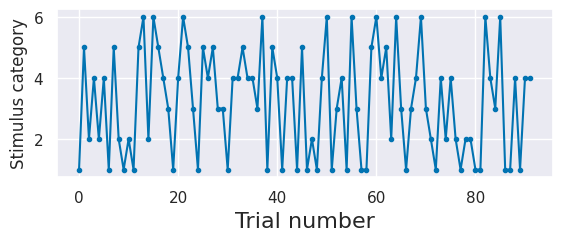

In [6]:
plt.figure()

# Label plot
plt.subplot(2,1,2)
plt.plot(labels,'.-')
plt.xlabel('Trial number', fontsize=16)
plt.ylabel('Stimulus category', fontsize=12)

<div class="alert alert-block alert-warning">
Notice that the category order is random i.e. the stimuli at every point are from a different category compared to the neighbors.
</div>

#### 1.3.1.2 Plotting the rFFA data
Let's remind ourselves which ROIs are in the data and in what order

In [7]:
print('ROI names: ', roi_names)

ROI names:  ['lFFA', 'rFFA', 'lPPA', 'rPPA']


Next, we will plot the data from rthe rFFA ROI.

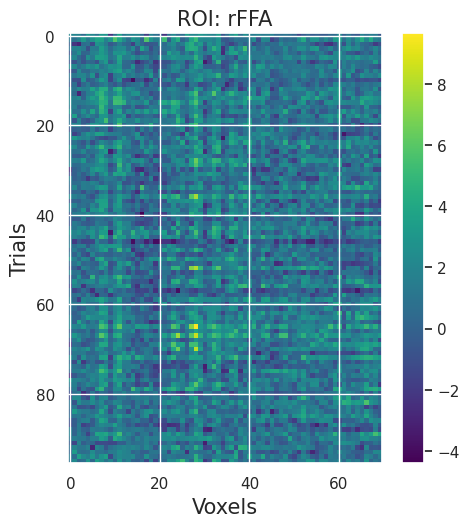

In [8]:
# Choose your ROI here (rFFA=1)!
roi_id = 1
# Create a data matrix R
R=roi_data[roi_id]
#Plot it
fig, axis = plt.subplots(1,1, figsize=(5, 5))
fig.tight_layout()
plt.imshow(R,cmap='viridis')
axis.set_title("ROI: rFFA", fontsize=15)
axis.set_xlabel("Voxels", fontsize=15)
axis.set_ylabel("Trials", fontsize=15)
plt.colorbar()

## 2. Create a similarity matrix <a id="sim_mat"></a>

Let's examine the similarity of the neural representations of each image with the neural patterns of every other image in the dataset. If the neural patterns are similar between images, we will see high values of similarity, but if the neural patterns are dissimilar, we will see low values of similarity. 

There are many ways to compute similarity. We start with one of the most common measures of similarity that you are already familiar with: Pearson correlation (see notebook-04). We compute the Pearson correlation on the neural pattern for each image with every other image. We can compute this on data for each of the ROIs that we have just loaded (left and right FFA, and left and right PPA). For each ROI, our computation will result in a 92 x 92 matrix (we only have labels for 92 images). This resulting matrix shows how similar the neural patterns of activity are between images and is called the representational **similarity** matrix (RSM).

Text(0, 0.5, 'trial number')

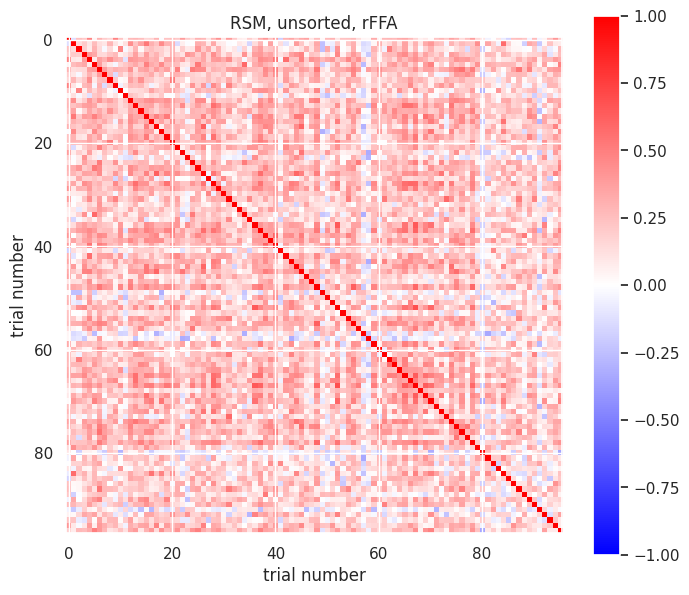

In [10]:
# Choose your ROI here!
roi_id = 1

# Plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))
plt.imshow(np.corrcoef(roi_data[roi_id]), cmap='bwr', vmin=-1,vmax=1,)
plt.colorbar()
ax.set_title('RSM, unsorted, %s' % (roi_names[roi_id])) 
ax.set_xlabel('trial number')
ax.set_ylabel('trial number')

### 2.1 Reorder data into categories <a id="reorder"></a>

Although the plot above is useful, it is hard to observe any structure because the order of the stimuli is random. To simplify, let's reorganize into label groups.

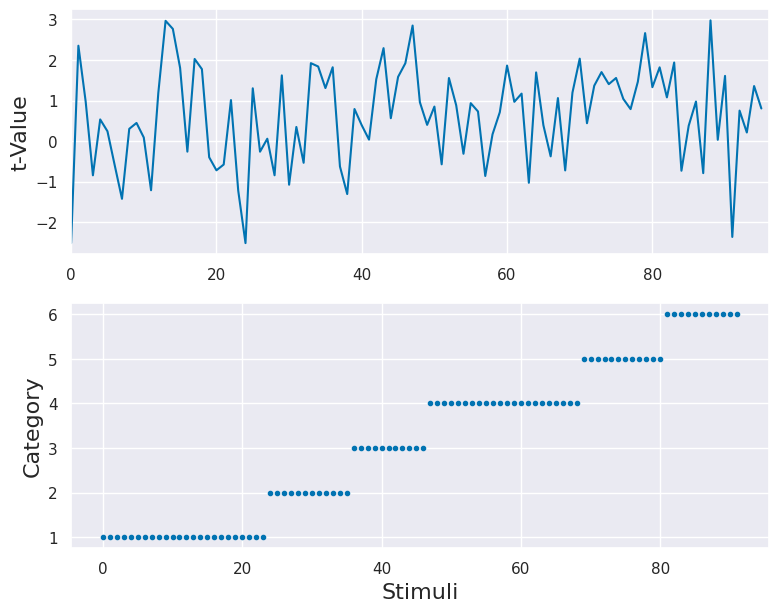

In [12]:
# Add the stimulus condition labels so that we can sort the data, collecting rows from the same condition together.
sort_ids = labels.argsort()
rffa_sorted = roi_data[1][sort_ids, :]

plt.figure(figsize=(9,7))

# Plot the effects from one voxel with the new sorted results
plt.subplot(2,1,1)
plt.plot(rffa_sorted[:,0])
plt.ylabel('t-Value', fontsize=16)
plt.xlim(0, 96)

plt.subplot(2,1,2)
plt.plot(labels[sort_ids],'.')
plt.xlabel('Stimuli', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.show()

Text(0.5, 1.0, 'RSM, sorted, rFFA')

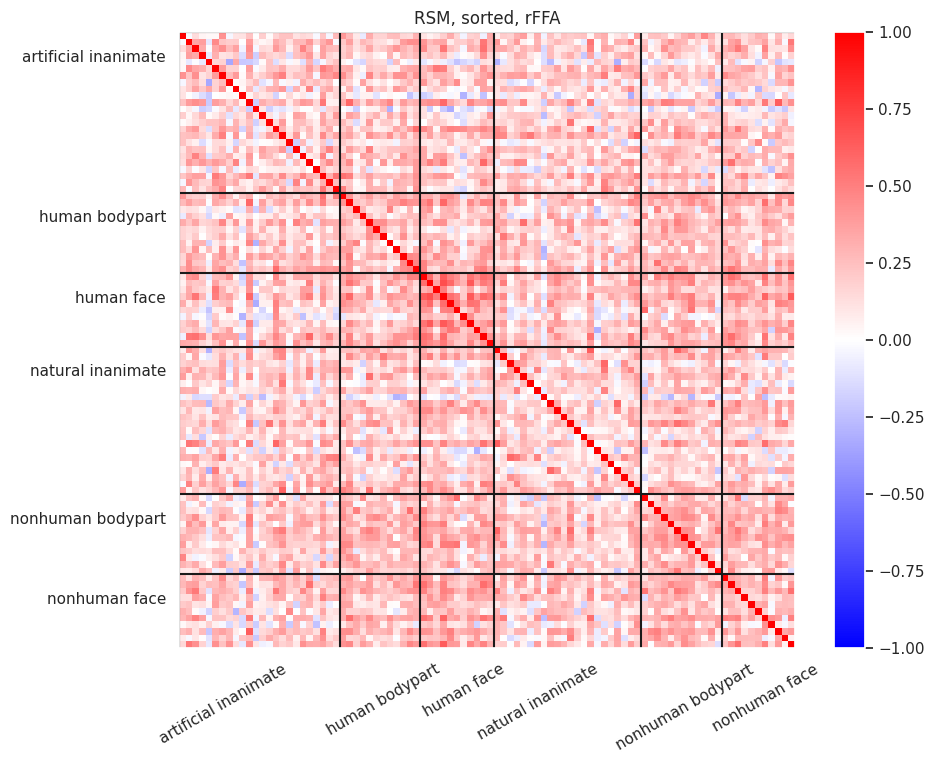

In [96]:
# Choose your ROI here! 
roi_id = 1

# Calculate the RSM
rsm = np.corrcoef(roi_data[roi_id][sort_ids, :][:92,]) # only include the first 92 trials, the last 4 are NaNs.

# Plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(rsm, cmap='bwr', vmin=-1, vmax=1,)
plt.colorbar()
plt.grid(False)

# Pull out the bin edges between the different categories
binsize = np.histogram(labels[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+6))
ax.set_xticklabels(categories, rotation = 30)
ax.set_yticks(list(np.array(edges)+3))
ax.set_yticklabels(categories)
ax.vlines(edges-0.5,0-0.5,91.5, colors="k")
ax.hlines(edges-0.5,0-0.5,91.5, colors = "k")

ax.set_title('RSM, sorted, %s' % roi_names[roi_id])


<div class="alert alert-block alert-warning">
<strong>Binning the data:</strong> In Figure 1 of Kriegeskorte et al. (2008), the raw correlation values were binned into ten bins based on the percentile score of the dissimilarity value, and the percentile value was plotted. We have created a function `digitize_rdm` to perform the same calculation here and make the plots similar to Figure 1 in Kriegeskorte et al. (2008). 
<br>    
<br>
Note that Figure 1 was using dissimilarity rather than similarity and that the data were from a different ROI (inferior temporal cortex, or IT). However, we can apply the same function to our RSM, the only difference being that the percentile will be based on similarity. 
<br>    
<br>
The `digitize_rdm` functions works in the following manner:  
<br>    
<br>
1. Create `n_bins` of percentile values.  <br>
2. Take in the matrix of correlations and reshape it into a single row. <br> 
3. Determine the percentile value of every correlation point and assign it to a bin (`np.digitize` does this).  <br>
4. Reshape the assigned percentile values into the original correlation matrix shape.  <br>
5. Finally, plot the percentile values.<br>
<br>
</div>

Text(0.5, 1.0, 'RSM digitized rFFA')

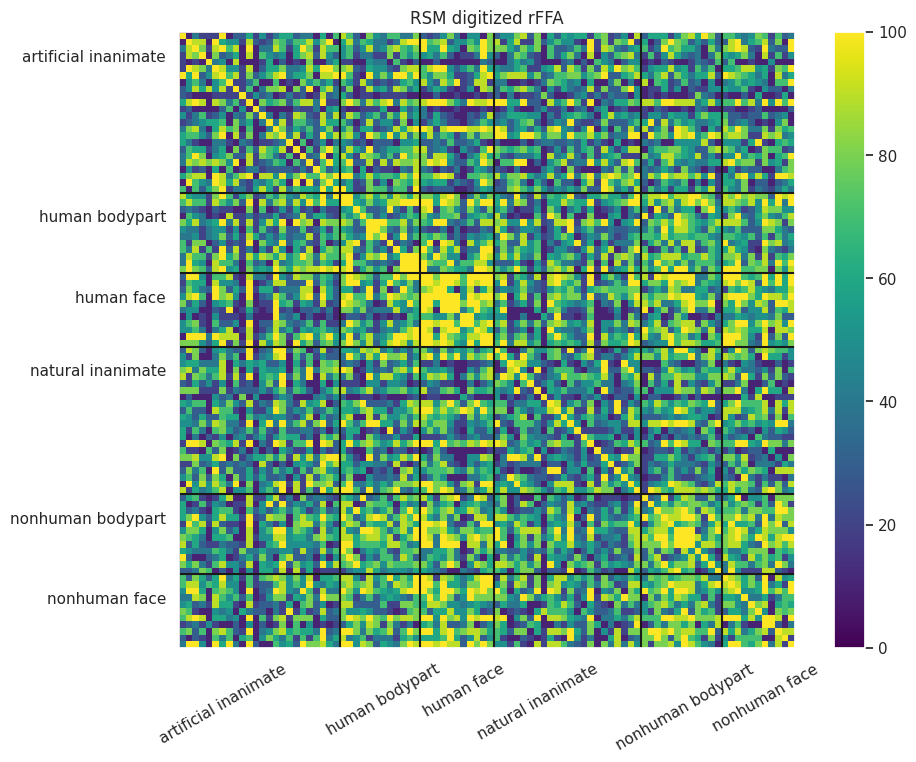

In [100]:
# Plot the RSM
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(digitize_rdm(rsm), cmap='viridis', vmin = 0, vmax = 100)
plt.colorbar()
plt.grid(False)

# Pull out the bin edges between the different categories
binsize = np.histogram(labels[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+6))
ax.set_xticklabels(categories, rotation = 30)
ax.set_yticks(list(np.array(edges)+3))
ax.set_yticklabels(categories)
ax.vlines(edges-0.5,0-0.5,91.5, colors="k")
ax.hlines(edges-0.5,0-0.5,91.5, colors = "k")
ax.set_title('RSM digitized %s' % roi_names[roi_id])

### 2.1.1 Reorder data in meaningful way
This new organization is helpful but could be improved (based on our knowledge of the brain). Order the datapoints so that the categories are as follows: human face, human body part, non-human face, non-human body part, natural inanimate and artificial inanimate. This will make for a nicer looking correlation matrix and will help you see any structure within and between categories. 

- Write a function to re-order the data. 
- Recompute the RSM based on the re-ordered data and visualize it.
- Visualize the digitized RSM using the digitization function provided earlier. 

In [12]:
print(categories)

['artificial inanimate', 'human bodypart', 'human face', 'natural inanimate', 'nonhuman bodypart', 'nonhuman face']


In [101]:
# Add the stimulus condition labels so that we can sort the data, collecting rows from the same condition together.
new_order=('human face', 'human bodypart', 'nonhuman face', 'nonhuman bodypart', 'natural inanimate', 'artificial inanimate')

# Make a loop to make a vector of new labels
category_vec=[]
labels2=[]
for nn in range(len(labels[:92,])):
    #Make a vector with category names, rather than numeric labels
    category_vec.append(categories[int(labels[nn]-1)])
    
    # Compare current category to new order, to make a vector of labels according the the new order
    for nnn in range(len(new_order)):
        if category_vec[nn]==new_order[nnn]:
            labels2.append(nnn)

##Inspect outcome
#print(category_vec)
#print(len(labels2))

#Make a new sorting index to use for plotting
labels2=np.array(labels2)
sort_ids2 = labels2.argsort()


Plot the reordered categories using the same code as above.

Text(0.5, 1.0, 'RSM digitized rFFA')

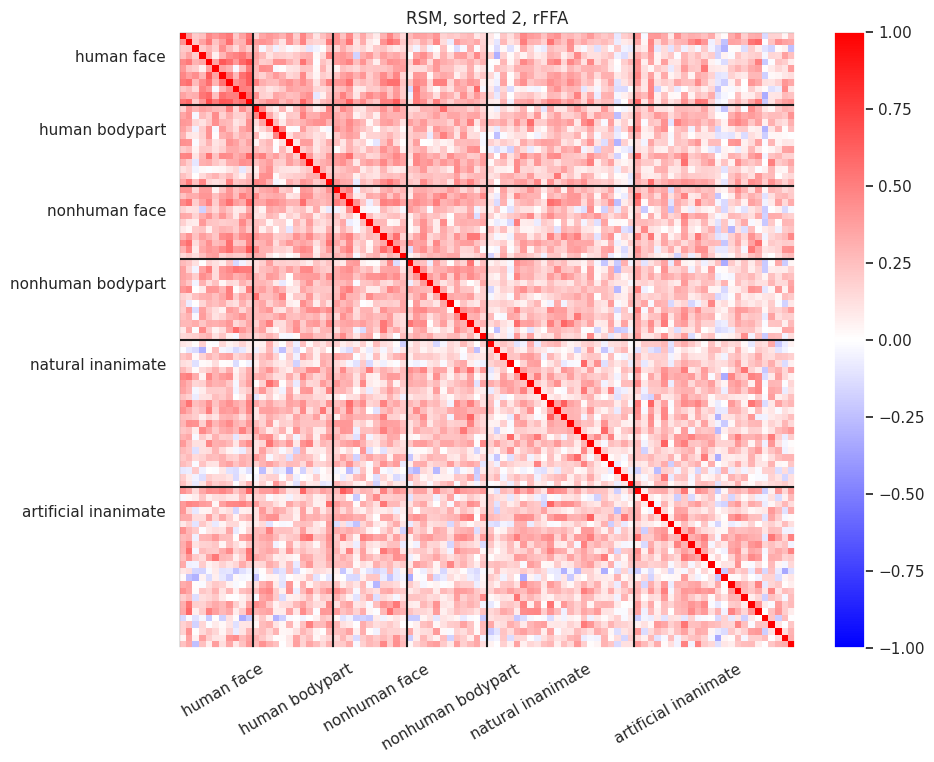

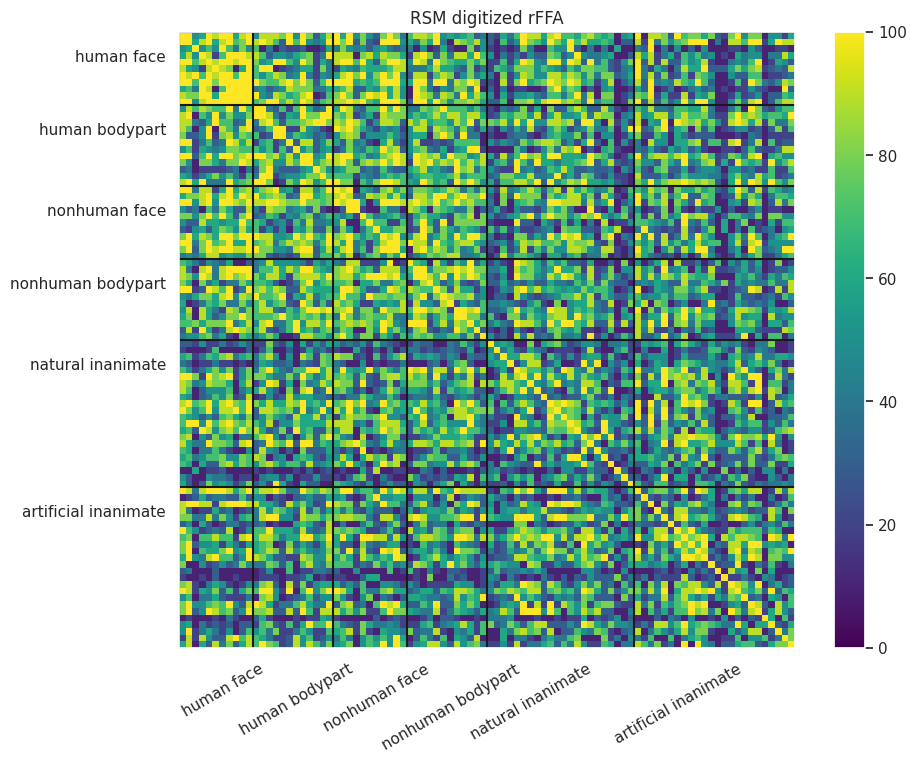

In [105]:
# Choose your ROI here! 
roi_id = 1

# Calculate the RSM
R=roi_data[roi_id][sort_ids2, :][:92,]
rsm2 = np.corrcoef(R) # only include the first 92 trials, the last 4 are NaNs.

# Plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(rsm2, cmap='bwr', vmin=-1,vmax=1,)
plt.colorbar()
plt.grid(False)

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+6))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+3))
ax.set_yticklabels(new_order)
ax.vlines(edges-0.5,0-0.5,91.5, colors="k")
ax.hlines(edges-0.5,0-0.5,91.5, colors = "k")
ax.set_title('RSM, sorted 2, %s' % roi_names[roi_id])

# Plot the digitized RSM
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(digitize_rdm(rsm2), cmap='viridis',vmin = 0, vmax = 100 )
plt.colorbar()
plt.grid(False)
# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+6))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+3))
ax.set_yticklabels(new_order)
ax.vlines(edges-0.5,0-0.5,91.5, colors="k")
ax.hlines(edges-0.5,0-0.5,91.5, colors = "k")
ax.set_title('RSM digitized %s' % roi_names[roi_id])

### 2.2 How to read a similarity matrix <a id="read_sim_mat"></a>

It is important to be able to read a similarity matrix at a glance. There are couple features to look out for and we will highlight these with some toy data.

Imagine a scenario where we have 12 trial types (e.g., images) grouped into 4 categories (e.g., faces, objects, body parts, and scenes). We are going to simulate some data that has similar activity within category but different activity between categories.

#### 2.2.1. Create simulated data. 

In [106]:
trial_types = 12
n_sim_categories = 4
repetitions_per_trial = 24
trial_noise = 0.5 # multiplying factor for the noise for each trial.
trials_per_category = int(trial_types / n_sim_categories)

# The template per category. One common signal per category. 
# This will be the similarity within category.
category_templates = np.random.randn(n_sim_categories, repetitions_per_trial)

# Add some noise to each trial and add the category template to each trial.
# This will create the trial activity.
trials = np.zeros((trial_types, repetitions_per_trial))
for category_counter in range(n_sim_categories):
    category_trials = np.random.randn(trials_per_category, repetitions_per_trial) * trial_noise
    for trial_counter in range(trials_per_category):
        trials[(trials_per_category * category_counter) + trial_counter, :] = category_templates[category_counter, :] + category_trials[trial_counter, :]



#### 2.2.2. Compute correlation and plot the result

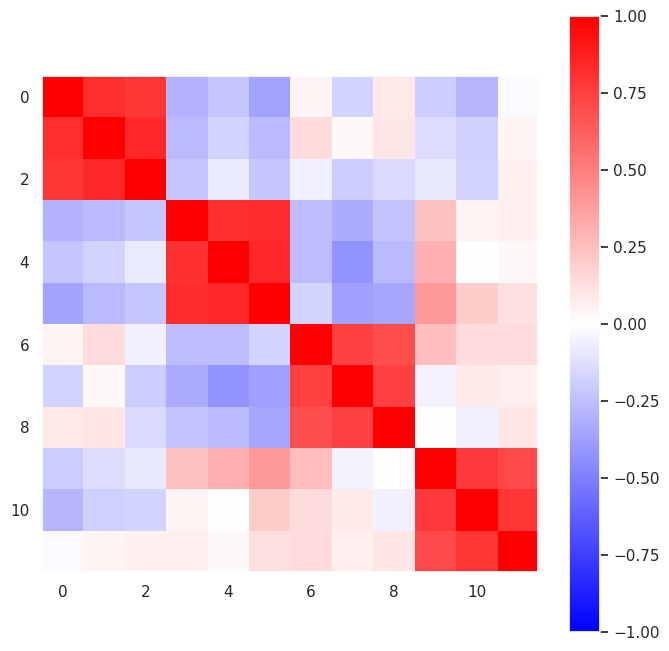

In [108]:
# Create the correlation matrix    
sim_r1 = np.corrcoef(trials)
plt.figure(figsize=(8, 8))
plt.imshow(sim_r1, interpolation='none',cmap='bwr', vmin=-1,vmax=1,)
plt.colorbar()
plt.grid(False)

In the above plot you should see some clear blocking structure along the diagonal: items within a category are more similar to one another than they are to items in different categories.

#### 2.2.3. Make two categories similar and observe changes in the similarity matrix 

Below we create a plot where there is off-diagonal structure. High similarity in off-diagonal parts of a similarity matrix means that elements that are far apart in the ordering have similar structure. In this toy simulation we create an example where the first and third categories are similar to one another (i.e., faces and body parts).

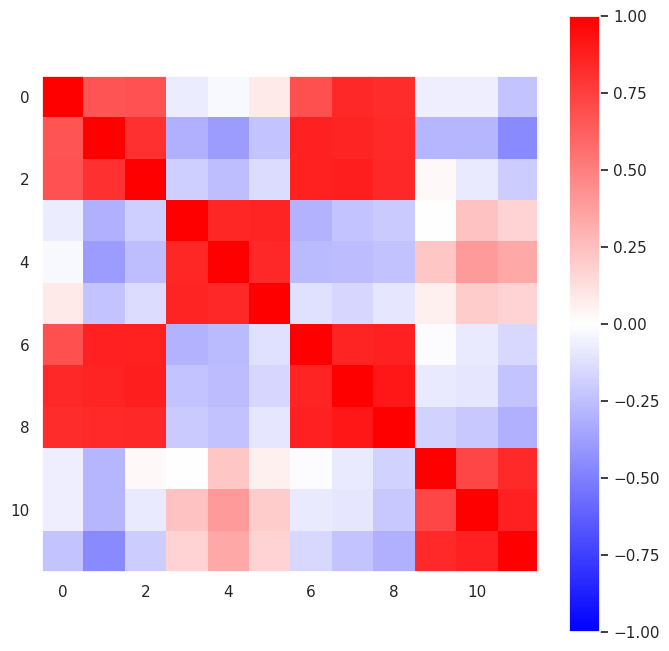

In [109]:
# Overwrite the template for the 3rd category with the template for 1st category. 
# Python indexing begins at [0].
category_templates[2, :] = category_templates[0, :]

# Create the trial activity
trials = np.zeros((trial_types, repetitions_per_trial))
for category_counter in range(n_sim_categories):
    category_trials = np.random.randn(trials_per_category, repetitions_per_trial) * trial_noise
    for trial_counter in range(trials_per_category):
        trials[(trials_per_category * category_counter) + trial_counter, :] = category_templates[category_counter, :] + category_trials[trial_counter, :]

# Create the correlation matrix    
sim_r2 = np.corrcoef(trials)
plt.figure(figsize=(8, 8))
plt.imshow(sim_r2, interpolation='none', cmap='bwr',   vmin=-1,  vmax=1,        )
plt.colorbar()
plt.grid(False)

### 2.3 Representational dissimilarity <a id="read_dsim_mat"></a>

The previous analyses framed everything in terms of similarity between the items. However people sometimes prefer to consider this type of data in terms of dissimilarity. This close cousin of the similarity matrix is called the representational dissimilarity matrix (RDM). The dissimilarity matrix can be computed as 1 - correlation.

Text(0.5, 1.0, 'RDM, sorted 2, rFFA')

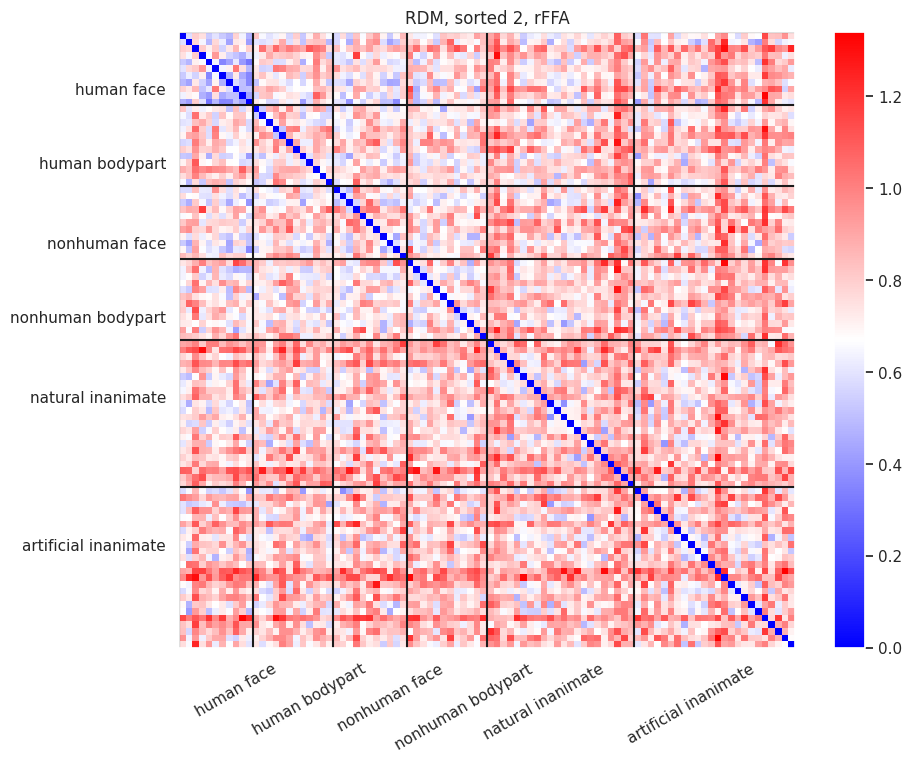

In [112]:
# Calculate the RSM
R=roi_data[roi_id][sort_ids2, :][:92,]
rdm = 1-np.corrcoef(R) # only include the first 92 trials, the last 4 are NaNs.

# Plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow( rdm,  cmap='bwr', )
plt.colorbar()
plt.grid(False)
# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges-0.5,0-0.5,91.5, colors="k")
ax.hlines(edges-0.5,0-0.5,91.5, colors = "k")

ax.set_title('RDM, sorted 2, %s' % roi_names[roi_id])

Each cell in a RDM represents a particular distance between two patterns.

You can start to think about RDMs as "inverse" correlation matrices in which cells do not represent correlations (a kind of *similarity* metric) but distances.

Once you start to think about RDMS as distance matrices, you can also start to imagine that you can use different *distance metrics*! There are many different functions you can use to quantify the dissimilarity between two vectors (i.e., two rows in our pattern matrix). We have seen that $1-r$ is a distance. This distance simply quantifies distance as the 1 minus the correlation between two patterns. For example, the $1-r$ distance between "pattern A" and "pattern B" is $1-\mathrm{corr(pattern\ A, pattern\ B})$.

In the RSA literature (and many other places), people often use the *cosine distance*, which is the angle between two vectors; when the patterns are mean centered (i.e., the rows in $\mathbf{R}$ have a mean of 0), this is exactly the same as the $1-r$ distance!

Another often-used distance metric used for RDMs, and perhaps the most intuitive one, is the Euclidean distance. This distance is computed as the square root of the sum of squared distances between two patterns (e.g., $p$ and $q$) consisting of $K$ elements:

\begin{align}
\delta_{euclidean} = \sqrt{\sum_{j=1}^{K}{(p_{j} - q_{j})^{2}}}
\end{align}

Scikit-learn actually provides several functions to quickly compute distance matrices (RDMs) using various distance metrics. For this, you can use the generic `pairwise_distances` function.

To compute an $N\times N$ distance matrix from a $N\times K$ pattern array ($\mathbf{R}$), you can use it as follows:
```python
rdm = pairwise_distances(R, metric='name_of_metric')
```

For example, to compute an RDM based on the "cosine" distance (which is similar to the $1-r$ distance), you can run:

Text(0.5, 1.0, 'RDM (cosine distance), sorted 2, rFFA')

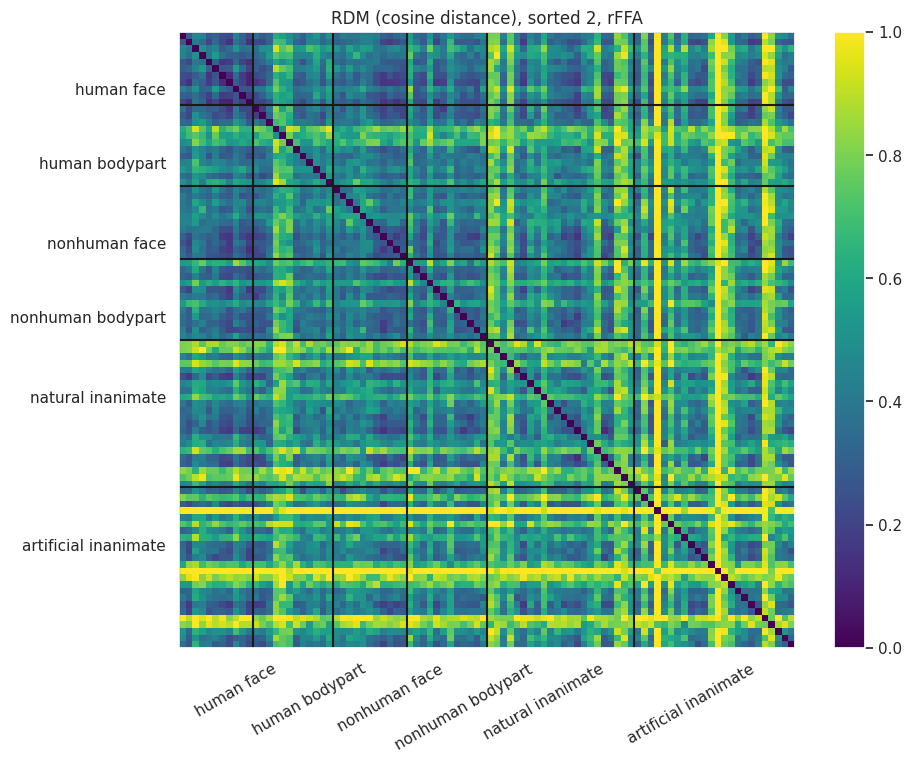

In [114]:
from sklearn.metrics import pairwise_distances

# Calculate the RDM
rdm_cos = pairwise_distances(R, metric='cosine')
#rdm_euc = pairwise_distances(R, metric='euclidian')

# Plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(rdm_cos, cmap='viridis', vmin=0, vmax=1)
plt.colorbar()
plt.grid(False)

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges-0.5,0-0.5,91.5, colors="k")
ax.hlines(edges-0.5,0-0.5,91.5, colors = "k")
ax.set_title('RDM (cosine distance), sorted 2, %s' % roi_names[roi_id])

#### Model the RDM data

In [118]:
labels_an=1*(labels2<=3)
labels_hum=1*(labels2<=1)
labels_hum_face=1*(labels2==0)# + 1*(labels2==2)

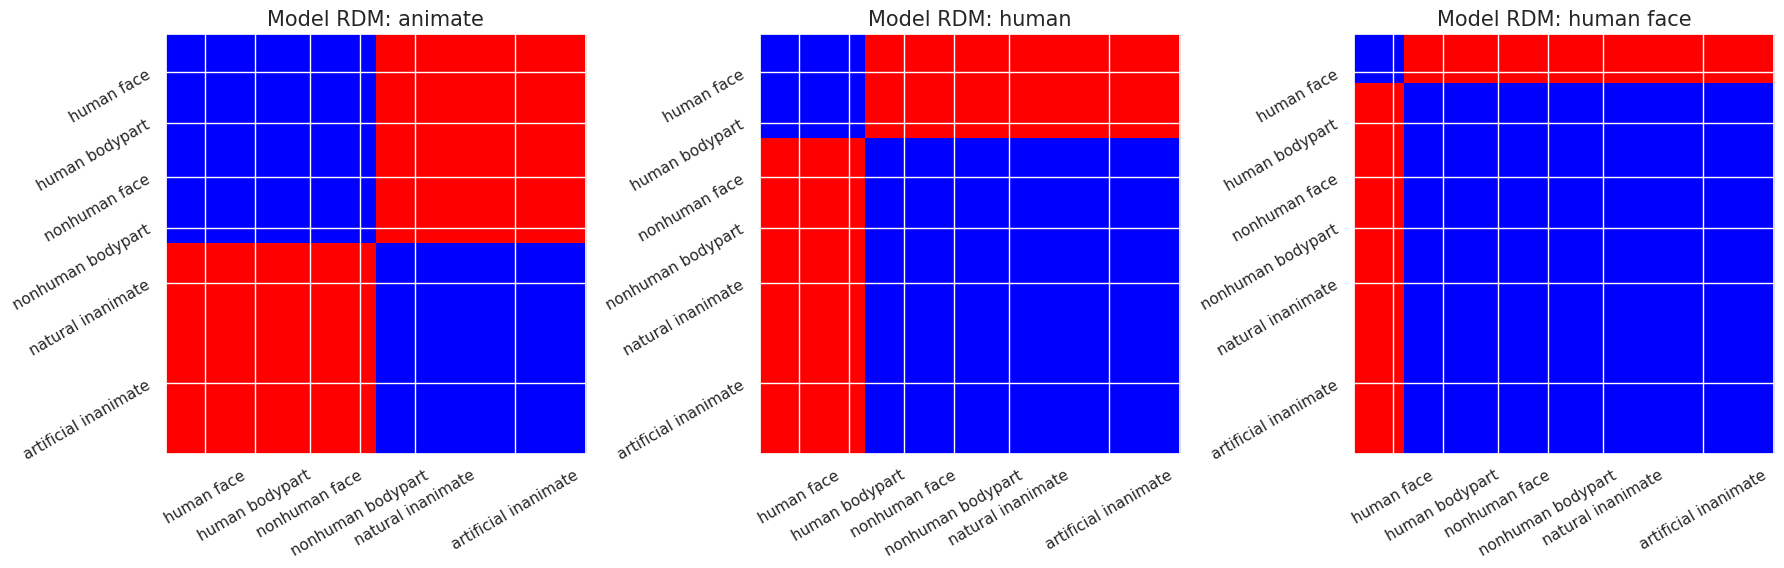

In [119]:
# Note the np.newaxis, which is needed because pairwise_distances
# assumes that the input is 2D

rdm_an = pairwise_distances(labels_an[sort_ids2, np.newaxis], metric='manhattan')
rdm_hum = pairwise_distances(labels_hum[sort_ids2, np.newaxis], metric='manhattan')
rdm_hum_face = pairwise_distances(labels_hum_face[sort_ids2, np.newaxis], metric='manhattan')

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
axes[0].imshow(rdm_an,cmap='bwr')
axes[0].set_title("Model RDM: animate", fontsize=15)
axes[1].imshow(rdm_hum,cmap='bwr')
axes[1].set_title("Model RDM: human", fontsize=15)
axes[2].imshow(rdm_hum_face,cmap='bwr')
axes[2].set_title("Model RDM: human face", fontsize=15)
for i in range(3):
    axes[i].set_xticks(list(np.array(edges)+8))
    axes[i].set_xticklabels(new_order, rotation = 30)
    axes[i].set_yticks(list(np.array(edges)+8))
    axes[i].set_yticklabels(new_order,rotation = 30)
fig.tight_layout()
fig.show()

Hmmm. These models assume short distance between categories of interest, but alse between categories not of interest. Can we do better?

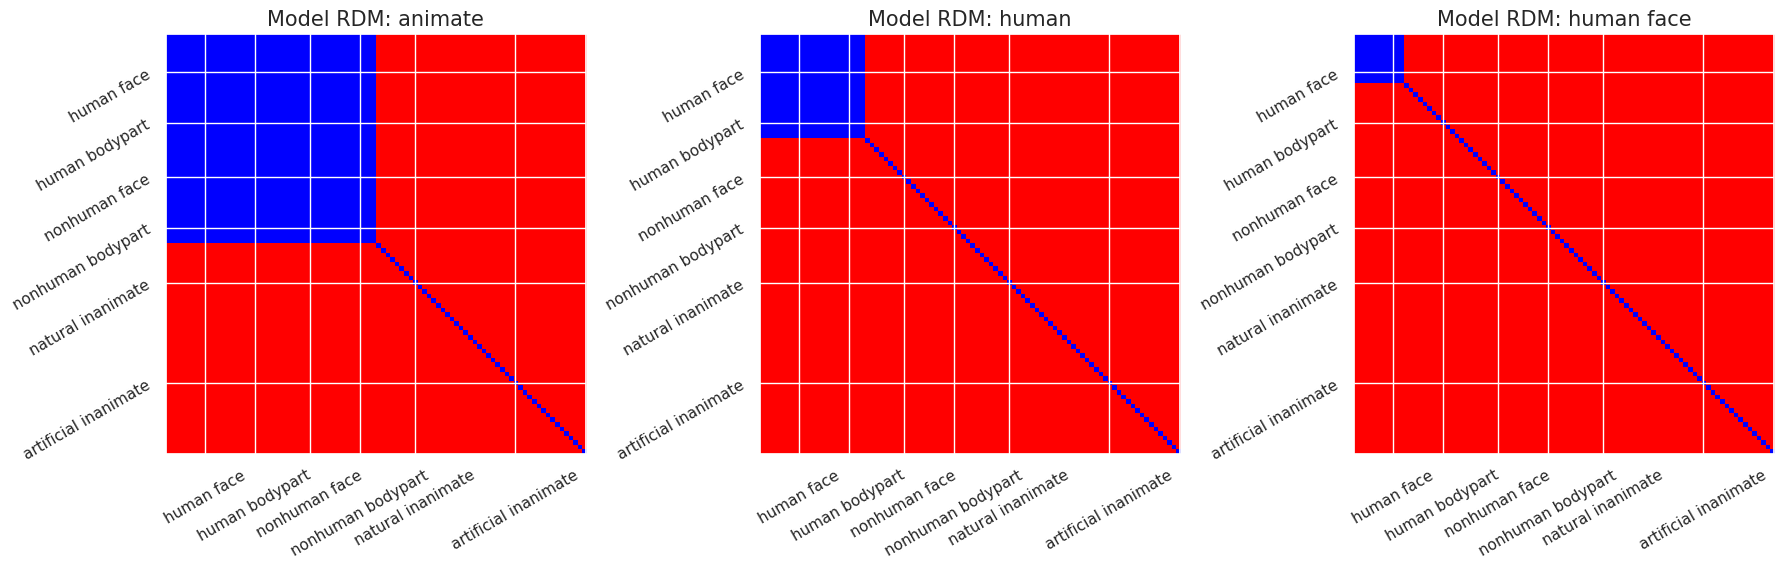

In [120]:
# Here is some ugly code to make alternative models
x1=np.tile(labels_an[sort_ids2],(sum(labels_an),1))
x2=np.zeros((len(labels_an)-sum(labels_an),len(labels_an)),dtype=int)
rdm_an2=abs(1-np.concatenate((x1,x2),axis=0))
np.fill_diagonal(rdm_an2,0)
x1=np.tile(labels_hum[sort_ids2],(sum(labels_hum),1))
x2=np.zeros((len(labels_hum)-sum(labels_hum),len(labels_hum)),dtype=int)
rdm_hum2=abs(1-np.concatenate((x1,x2),axis=0))
np.fill_diagonal(rdm_hum2,0)
x1=np.tile(labels_hum_face[sort_ids2],(sum(labels_hum_face),1))
x2=np.zeros((len(labels_hum_face)-sum(labels_hum_face),len(labels_hum_face)),dtype=int)
rdm_hum_face2=abs(1-np.concatenate((x1,x2),axis=0))
np.fill_diagonal(rdm_hum_face2,0)

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
axes[0].imshow(rdm_an2,cmap='bwr')
axes[0].set_title("Model RDM: animate", fontsize=15)
axes[1].imshow(rdm_hum2,cmap='bwr')
axes[1].set_title("Model RDM: human", fontsize=15)
axes[2].imshow(rdm_hum_face2,cmap='bwr')
axes[2].set_title("Model RDM: human face", fontsize=15)
for i in range(3):
    axes[i].set_xticks(list(np.array(edges)+8))
    axes[i].set_xticklabels(new_order, rotation = 30)
    axes[i].set_yticks(list(np.array(edges)+8))
    axes[i].set_yticklabels(new_order,rotation = 30)
fig.tight_layout()
fig.show()

This looks more intuitively correct. Short distances between some categories and larger between the rest.

## 2.3 Testing RDMs
In this section, we'll discuss how to evaluate the "fit" of feature RDMs.

### Correlation-based tests
Alright, so now we got two RDMs: the feature RDM and the neural RDM. To evaluate to what extent the two RDMs share the same representational geometry, we can simply correlate them! Before doing so, we have to do one more thing: extract the lower (or upper) triangle of the RDM. This is because RDMs are symmetric: the values above and below the diagonal are exactly the same. If we used the entire (flattened) RDM, we'd "artifically" create twice as many datapoints (i.e. the pairwise dissimilarities) than there really are, which will inflate the significance of the correlation between the RDMs because of increased sample size. So, instead of using all $N\cdot N$ pairwise differences from the RDM, we need to extract only the flattened $N\times (N-1)/2$ pairwise dissimilarity values, the "representational dissimilarity vector" (RDV) if you will. This means that we do not include the diagonal!

Fortunately, there is a function that easily extracts the lower triangle of a square distance matrix: `squareform` (from the `scipy.spatial.distance` module):

In [121]:
from scipy.spatial.distance import squareform

# Let's extract the RDV from our neural RDM
rdv_cos = squareform(rdm_cos.round(5))
print("Shape rdv_cos:", rdv_cos.shape)

Shape rdv_cos: (4186,)


<div class='alert alert-success'>
    <b>Tip</b>: Sometimes, an RDM might not be <em>exactly</em> symmetric due to floating point inaccuracies, which will give an error my trying to extract the lower triangle using <tt>squareform</tt>. To circumvent this, you can round the RDM values to, e.g., 5 decimals using the <tt>.round(decimals)</tt> array method.
</div>

As you can see, the shape of the `rdv_R` is as expected: $92 \times (92-1) / 2 = 4186$. Let's do the same for our RDM models we just created earlier (`rdm_an`,`rdm_hum`,`rdm_face`):

In [122]:
rdv_an = squareform(rdm_an2)
print("Shape rdv_an:", rdv_an.shape)
rdv_hum = squareform(rdm_hum2)
print("Shape rdv_hum:", rdv_an.shape)
rdv_hum_face = squareform(rdm_hum_face2)
print("Shape rdv_hum_face:", rdv_hum_face.shape)

Shape rdv_an: (4186,)
Shape rdv_hum: (4186,)
Shape rdv_hum_face: (4186,)


Importantly, the correlation between feature and neural RDMs is often evaluated using a rank-based correlation metric. For continuous feature RDMs, this is usually the Spearman correlation, but for categorical feature RDMs (such as our model RDMs), often the "Kendall Tau $\alpha$" correlation is used, as it deals properly with tied ranks. Implementations of both correlations are available from the `scipy.stats` module. Here, we'll use Kendall's Tau $\alpha$, because our model RDMs are categorical:

In [123]:
from scipy.stats import kendalltau
rdm_an_corr, pval = kendalltau(rdv_an, rdv_cos)
print("Correlation between animate RDM and RDM(rFFA cosine) (p-value): %.3f (%.3f)" % (rdm_an_corr, pval))
rdm_hum_corr, pval = kendalltau(rdv_hum, rdv_cos)
print("Correlation between human RDM and RDM(rFFA cosine) (p-value): %.3f (%.3f)" % (rdm_hum_corr, pval))
rdm_hum_face_corr, pval = kendalltau(rdv_hum_face, rdv_cos)
print("Correlation between face RDM and RDM(rFFA cosine) (p-value): %.3f (%.3f)" % (rdm_hum_face_corr, pval))

Correlation between animate RDM and RDM(rFFA cosine) (p-value): 0.251 (0.000)
Correlation between human RDM and RDM(rFFA cosine) (p-value): 0.095 (0.000)
Correlation between face RDM and RDM(rFFA cosine) (p-value): 0.112 (0.000)


### Reweighting RDVs
One more advanced RSA technique is "reweighting". This technique allows you to use multiple feature RDVs to explain your neural RDV. Essentially, you assume that the neural RDV can be approximated as a linear weighted sum of different feature RDVs. For example, for three feature RDVs ($\mathrm{RDV}_{S_{1}}$ and $\mathrm{RDV}_{S_{2}}$, $\mathrm{RDV}_{S_{2}}$):

\begin{align}
\mathrm{RDV}_{R} = \beta_{0} + \mathrm{RDV}_{S_{1}}\beta_{1} + \mathrm{RDV}_{S_{2}}\beta_{2} + \mathrm{RDV}_{S_{3}}\beta_{3}+ \epsilon
\end{align}

You might recognize this formulation as a linear model (GLM) with the neural RDV as dependent variable and the feature RDVs as independent variables. Here, the parameters ($\beta$) represent the "reweighting" factors. This technique is very useful to disentangle the contributions of different (possibly correlated) feature spaces. 

Note that often a variant of ordinary least squares (OLS) is used to determine the parameters: non-negative least squares (NNLS), which forces the parameters to be positive (for details about why NNLS should be used, see [this article](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003915), and more information about reweighting in general, see [this article](https://www.sciencedirect.com/science/article/pii/S0028393215301998#bib5)). 

After the reweighted RDV ($\mathrm{RDV}_{S}\hat{\beta}$) is computed, it can again be evaluated using a (rank-based) correlation: $r(\mathrm{RDV}_{S}\hat{\beta}, \mathrm{RDV}_{R})$.

Below, we perform a reweighting analysis with the three feature RDVs as independent variables (in addition to an intercept!) and the neural RDV (based on <tt>rdm_R</tt>) as dependent variable. We will use the <tt>nnls</tt> implementation from <tt>scipy.optimize</tt> to perform NNLS. Note that the <tt>nnls</tt> function returns two things &mdash; the first object is the array with parameters, and it takes two arguments: the design matrix (independent variables) and the dependent variable.

In [28]:
from scipy.stats import spearmanr
from scipy.optimize import nnls

# Make a design matrix with all our model matrices (human and human face) and a constant
dm = np.c_[
    rdv_hum,
    rdv_hum_face,
    np.ones_like(rdv_an)
]
#Fit the model using non-negative least squares
betas = nnls(dm, rdv_cos)

#Get the regression coefficients
beta_an=betas[0]
print("Beta-estimates from the fit:" ,beta_an.round(3))

# Find the fittet effects, i.e. those that can be explained by the model.
fitted_data=dm @ beta_an

#subract fitted data from the cos data to only leave what cannot be explained by to other variables
rdv_cos2=rdv_cos-fitted_data

#Conduct new correlation analysis to find the unique effect of animacy
rdm_an_corr_rw, pval_rw = kendalltau(rdv_an, rdv_cos2)

print("Reweighted correlation between animate RDM and RDM(rFFA cosine) (p-value): %.3f (%.3f)" % (rdm_an_corr_rw, pval_rw))

Beta-estimates from the fit: [0.082 0.188 0.301]
Reweighted correlation between animate RDM and RDM(rFFA cosine) (p-value): 0.202 (0.000)


### 2.4 Comparison of representations in monkeys and humans <a id="rdm-monkey-human"></a>

The RSA can be used to compare information not just in humans, but across species too. Below is comparison of the RDM for monkeys and humans, in the inferior temporal cortex (Color map altered to match Figure 1 in Kriegeskorte et al. (2008)).

Text(0.5, 1.0, 'Human RDM')

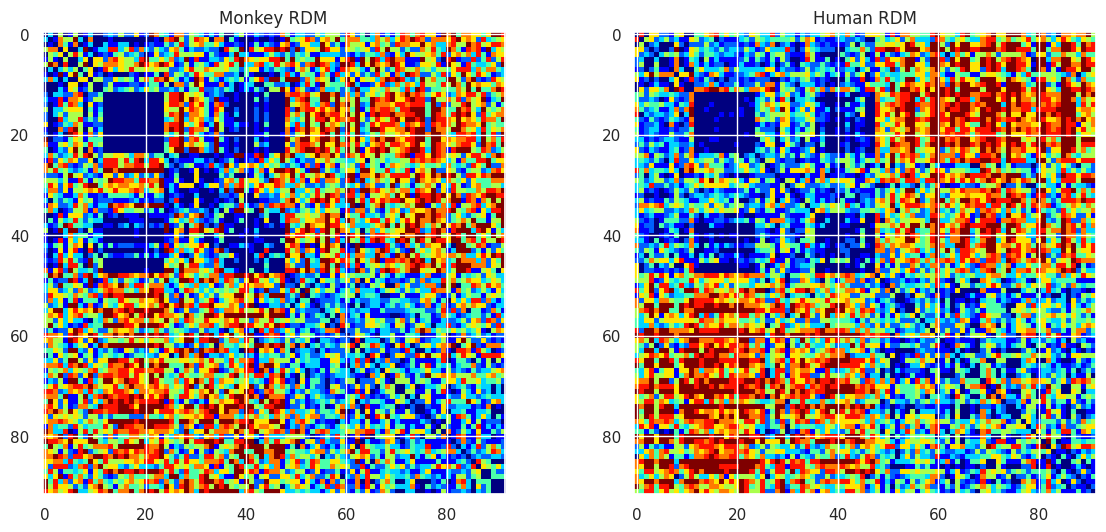

In [29]:
# Load the data, and bin to percentile
monkeyRDM = pd.read_csv(os.path.join(ns_data_dir, 'RDM_mIT_fig1.txt'), header=None)
humanRDM = pd.read_csv(os.path.join(ns_data_dir, 'RDM_hIT_fig1.txt'), header=None)

monkey_rdm_digitized = digitize_rdm(monkeyRDM)
human_rdm_digitized = digitize_rdm(humanRDM)

f, axes = plt.subplots(1,2, figsize = (14, 6))
axes[0].imshow(
    monkey_rdm_digitized, 
    cmap='jet', 
)
axes[1].imshow(
     human_rdm_digitized, 
     cmap='jet', 
)
# plt.colorbar()
axes[0].set_title('Monkey RDM')
axes[1].set_title('Human RDM')

#for i in range(2): 
#    axes[i].set_xlabel('stimuli id')
#    axes[i].set_ylabel('stimuli id')

## 3. Multi-dimensional scaling (MDS) <a id="mds"></a>

The correlation matrix for the 92 images describes how similar each item is to each other item. This means that if two items have a high positive correlation then they can be thought of as eliciting a very similar activation pattern across voxels. We can reframe this to be thought of as a distance in a high-dimensional space. From this perspective, items that are similar to one another will be grouped close together and far away from points that they are dissimilar to. 

MDS allows us to visualize the similarity of our data in a different way than plotting the matrices above. Specifically, it allows to generate a lower-dimensional image (e.g., 2-D or 3-D) in which the distances between points approximate the distances in the original high-dimensional data. There is an MDS [method](https://homepages.uni-tuebingen.de/florian.wickelmaier/pubs/Wickelmaier2003SQRU.pdf) built into [scikit-learn](http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling).

In [30]:
# Create a 2-D MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)  # Create the MDS object
results = mds.fit(digitize_rdm(1 - rsm))  # Use the dissimilarity matrix

**Exercise 7:**<a id="ex7"></a> How does changing the order of the data (e.g., shuffling the rows/columns) in your RDM affect the distance between points calculated by MDS? 

**A:**

### 3.1 Plot the 2D structure of the RDM <a id="plot_2d"></a>

We'll plot the 92 images on a "map" signifying how close or far apart images are to each other. We use different colors for the 6 categories of images.

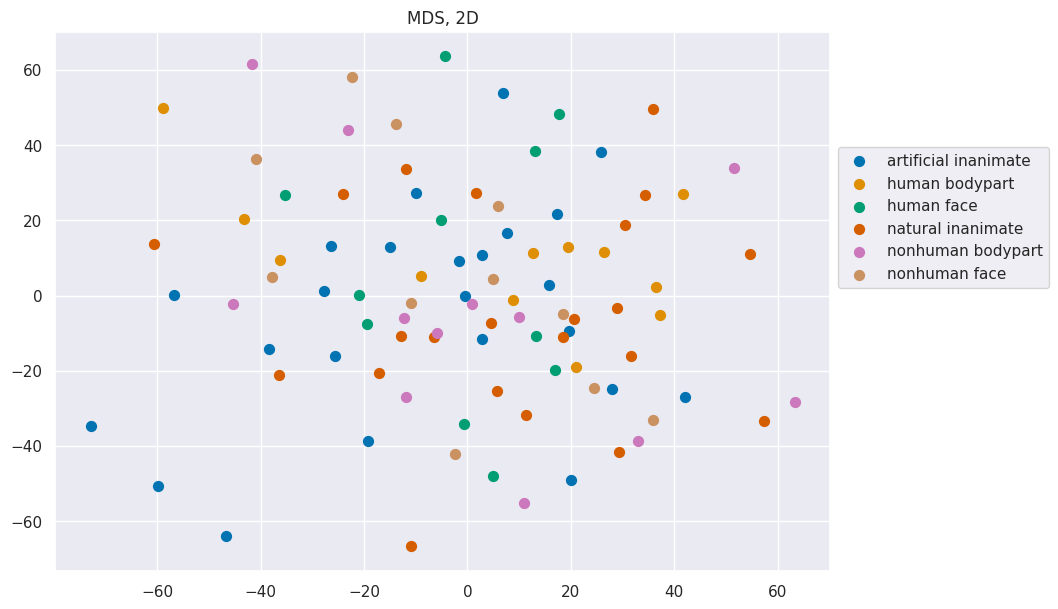

In [31]:
coords = results.embedding_

plt.figure(figsize=(10, 7))
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:92] == label_counter)[:]
    plt.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1], 
        marker = 'o', s = 50
        )
plt.legend(categories, bbox_to_anchor=(1, .8), loc="upper left")
plt.title('MDS, 2D');

**Self-study**: On the MDS plot you are currently plotting each item as a point. You could instead load in each image and plot that image on the MDS plot directly to get a feel for which stimuli are being grouped.

### 3.2 Plot the 3D structure of the RDM <a id="plot_3d"></a>

MDS is just trying to find a k-dimensional embedding that minimizes the stress (something akin to the goodness of fit). This means we can actually plot it in arbitrarily high dimensions to try and capture the data structure. Below we make a 3D plot, given that the 2D plot.

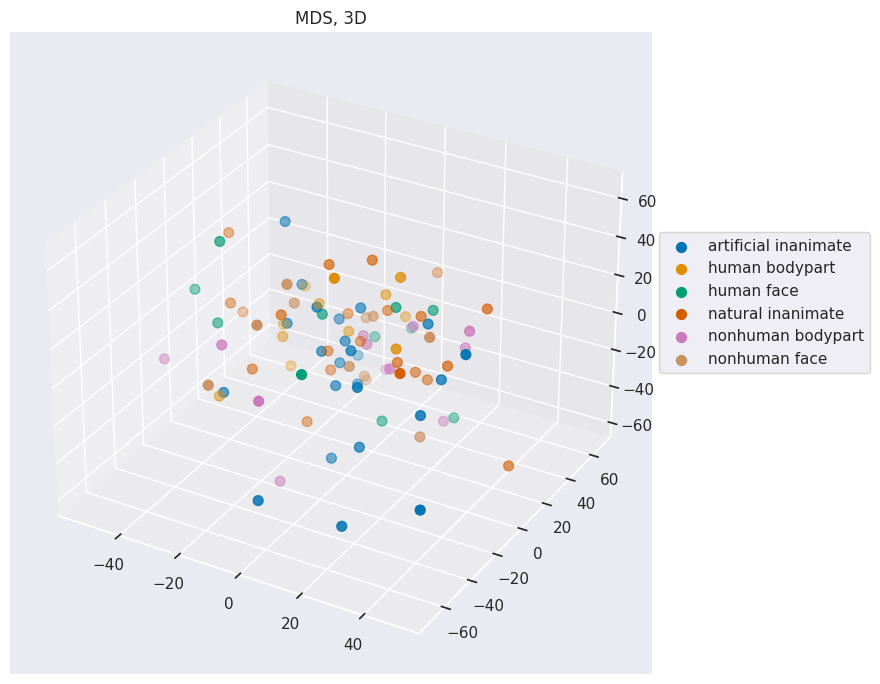

In [32]:
# Multi-dimensional scaling
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
results = mds.fit(digitize_rdm(1 - rsm))

coords = results.embedding_

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:92] == label_counter)[:]
    ax.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1], coords[label_idxs, 2], 
        marker = 'o', s = 50
    )
    
plt.legend(categories, bbox_to_anchor=(1,.7), loc="upper left")
plt.title('MDS, 3D')
plt.tight_layout()

There are tools available to us to evaluate what is the appropriate dimensionality for visualization of our data (i.e. what dimensionality has sufficiently low stress). We can look at the stress of the MDS with different numbers of components (i.e. different dimensionality) and determine what dimensionality of the data is appropriate.

Let's make a toy problem to start off with in order to get a handle on what this should look like. We are going to make points that lie on a line in 3D space. Because a line has only one dimension of information (along its length) the data ought to be able to be reduced in dimensionality to a single dimension. We will run MDS on this data to see if that is the case.

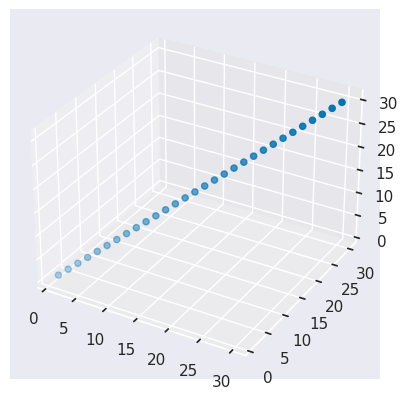

In [33]:
coords = np.linspace(1, 30, 30)
coords = np.vstack((coords, coords, coords)).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2])

Text(0.5, 0, 'Dimensionality')

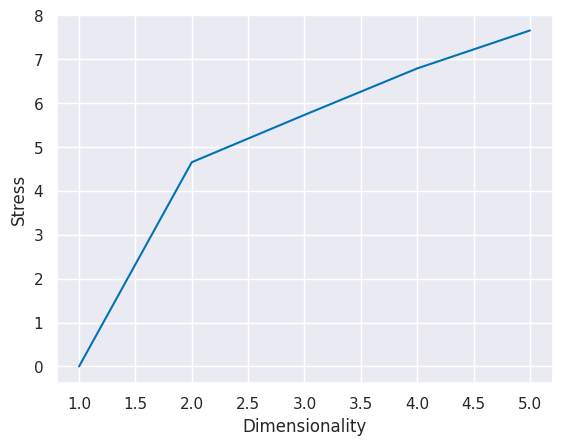

In [34]:
# Calculate the euclidean distance of every point from every other point
dist = sp_distance.squareform(sp_distance.pdist(coords))

# Iterate through different numbers of components
stress = []
for components in range(1, 6):
    mds = MDS(n_components=components, dissimilarity="precomputed", random_state=0)
    # Pull out the stress of the MDS fit
    stress.append(mds.fit(dist).stress_)

# Plot the stress
plt.figure()
plt.plot(range(1, 6), stress)
plt.ylabel('Stress')
plt.xlabel('Dimensionality')